## ANN Model Development for Electric Water Boilers
- The first model is developed as an ANN prediction model.

- The second is designed as an ANN forecasting model.

- A combined model integrates both prediction and forecasting capabilities.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### ANN prediction model as a standalone module

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Performance Metrics:
MAE:  0.0314
RMSE: 0.0476
R²:   0.9161


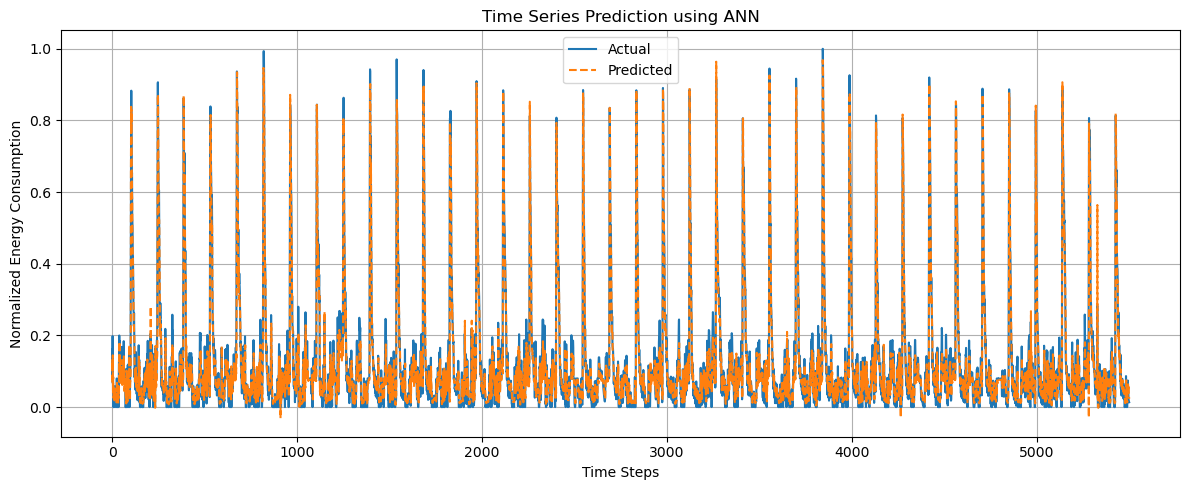

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('eleload.csv')
values = data.iloc[:, -1].values.astype(float)

# Normalize
values = values / np.max(values)

# -Define function to create lagged features
def create_lagged_data(series, lag=6):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Parameters ---
n_lags = 6   #  previous time steps
X, y = create_lagged_data(values, lag=n_lags)



# Train-test split ---
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# --- Define ANN model ---
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_lags,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])




# Train model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0)



#  Prediction
y_pred = model.predict(X_test)

# --- results--
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot predictions vs actual ---
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Time Series Prediction using ANN')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ANN forecasting model as a separate standalone module

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Prediction Performance Metrics:
MAE:  0.0308
RMSE: 0.0462
R²:   0.9210


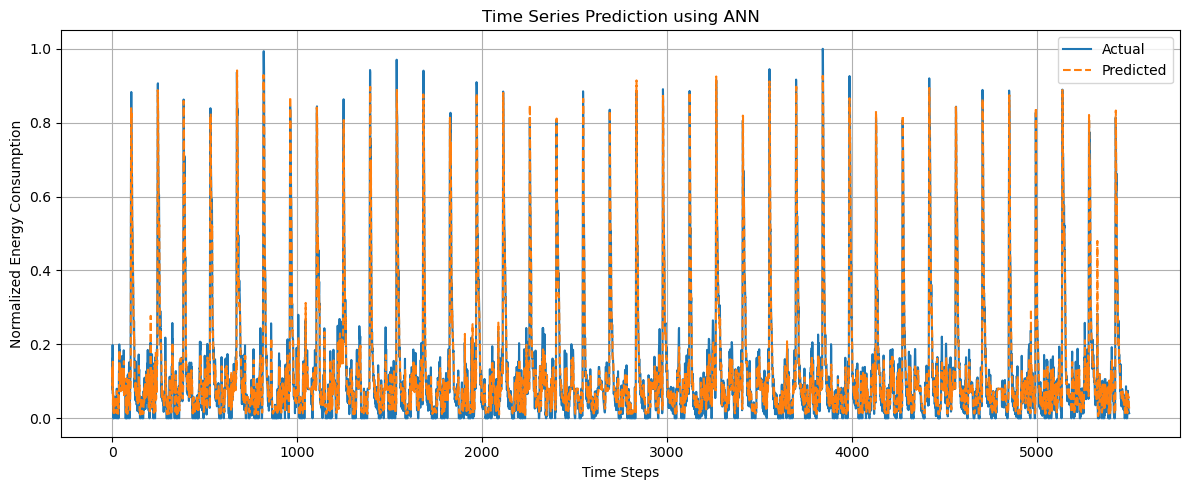

In [3]:
# --- Load data ---
data = pd.read_csv('eleload.csv')
values = data.iloc[:, -1].values.astype(float)

# --- Normalize data ---
values = values / np.max(values)

# --- Define function to create lagged features ---
def create_lagged_data(series, lag=6):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# --- Parameters ---
n_lags = 6   # number of previous time steps to use
X, y = create_lagged_data(values, lag=n_lags)

# --- Train-test split ---
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# --- Define ANN model ---
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_lags,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),   
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Train model ---
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0)

########## Prediction ##################
y_pred = model.predict(X_test)

# --- Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Prediction Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot predictions vs actual ---
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Time Series Prediction using ANN')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Combined ANN prediction and forecasting model as a unified standalone module

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🔹 Prediction Results:
  R2 Score: 0.9802324599236687
  RMSE    : 44.82941545265697
  MAE     : 23.0657057956413
  MSE     : 2009.6764898269191

🔹 Forecasting Results:
  R2 Score: 0.9432541739962281
  RMSE    : 77.87143923869745
  MAE     : 58.79524269810429
  MSE     : 6063.9610491061485


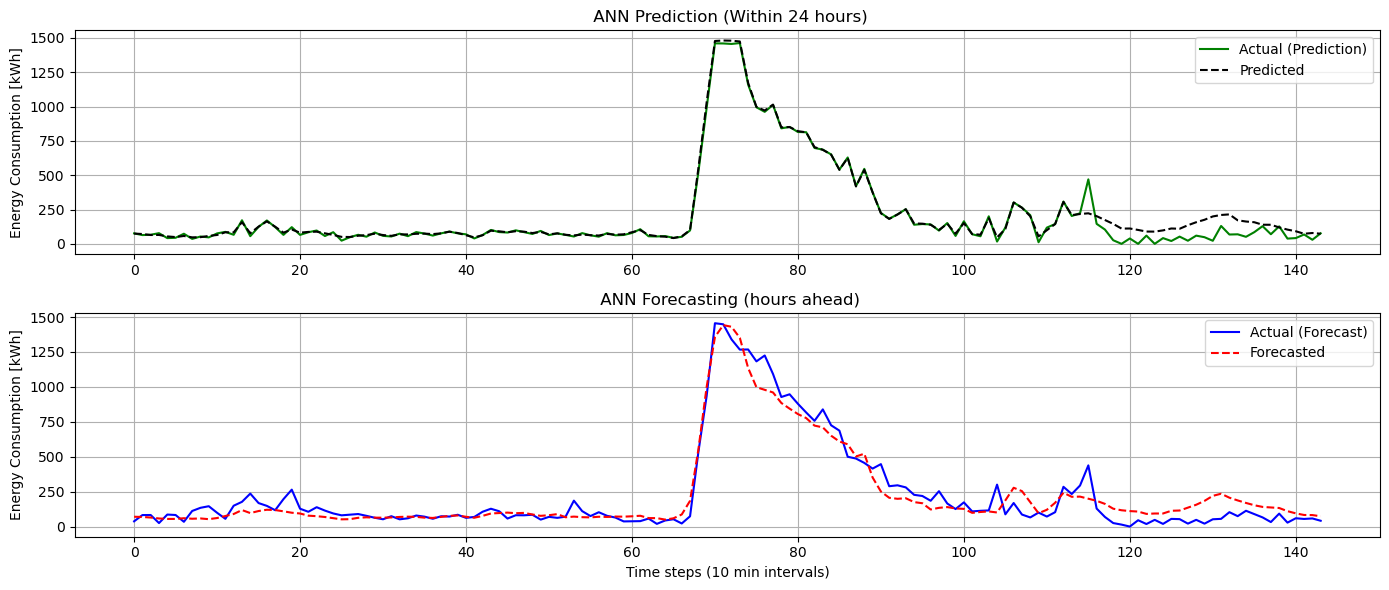

In [9]:

##########        Load and processing data ##########


df = pd.read_csv('electric.csv')
data_raw = df.iloc[:, -1].values  # mean column of all apartments
max_val = np.max(data_raw)
data = data_raw / max_val  # Normalize



# ############### Parameters inputs  ###############

window_size = 2000   # lag steps
pred_len = 144     # Prediction within known time (24 hours)
forecast_len = 144  # Forecasting future steps (12 hours)




# ################### Create dataset for ANN ###############

def create_supervised_data(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X, y = create_supervised_data(data, window_size)



########### Split data ##########

X_pred = X[:pred_len]
y_pred = y[:pred_len]

X_forecast = X[pred_len:pred_len + forecast_len]
y_forecast = y[pred_len:pred_len + forecast_len]




############# ANN Model ######

def build_ann_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),  
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

model = build_ann_model(X.shape[1])
history = model.fit(
    X_pred, y_pred,
    epochs=200,
    batch_size=16,
    verbose=0,
    validation_split=0.2
)

# Predict & Forecast#######

y_pred_hat = model.predict(X_pred).flatten()
y_forecast_hat = model.predict(X_forecast).flatten()



# --- Inverse normalization ##########

y_pred_actual = y_pred * max_val
y_pred_hat_actual = y_pred_hat * max_val

y_forecast_actual = y_forecast * max_val
y_forecast_hat_actual = y_forecast_hat * max_val







# Evaluation ###############

def print_metrics(y_true, y_hat, label=''):
    print(f"\n🔹 {label} Results:")
    print("  R2 Score:", r2_score(y_true, y_hat))
    print("  RMSE    :", np.sqrt(mean_squared_error(y_true, y_hat)))
    print("  MAE     :", mean_absolute_error(y_true, y_hat))
    print("  MSE     :", mean_squared_error(y_true, y_hat))

print_metrics(y_pred_actual, y_pred_hat_actual, "Prediction")

print_metrics(y_forecast_actual, y_forecast_hat_actual, "Forecasting")








########### Plotting predictions and forecasting #############

plt.figure(figsize=(14, 6))

# ANN Prediction Plot #################

plt.subplot(2, 1, 1)
plt.plot(y_pred_actual, label='Actual (Prediction)', color='green')
plt.plot(y_pred_hat_actual, label='Predicted', linestyle='--', color='black')
plt.title(" ANN prediction (Within 24 hours)")
plt.ylabel('Energy consumption [kWh]')
plt.legend()
plt.grid(True)



# ANN Forecasting Plot
plt.subplot(2, 1, 2)
plt.plot(y_forecast_actual, label='Actual (Forecast)', color='blue')
plt.plot(y_forecast_hat_actual, label='Forecasted', linestyle='--', color='red')
plt.title(" ANN forecasting (hours ahead)")
plt.xlabel('Time steps (10 min intervals)')
plt.ylabel('Energy consumption [kWh]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("ann_pred_forecast_comparison.png")
plt.show()
